In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import ast
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, Model
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud

In [2]:
df = pd.read_csv("./Dataset/combined_design_dataset.csv")
df.head(10)

,description,font,color_palette
0,A modern tech startup website,Rouge Script,"#b96460,#563371,#b78936,#82dc2c,#28b34e"
1,A vintage coffee shop menu,Patua One,"#35ae97,#4917e8,#3edec7,#2d0b25,#f8bb90"
2,A minimalist photography portfolio,Numans,"#a90421,#cd8643,#dc2b6c,#10c5bb,#15c835"
3,A vibrant fashion e-commerce site,Bangers,"#68f006,#e8aca2,#01b2fe,#f07642,#aa299d"
4,A cozy bookstore flyer,Brawler,"#6779b6,#c2610f,#0ea5e3,#4b906a,#cd97bc"
5,A professional corporate business website,Delius Unicase,"#b7ee81,#8e29cd,#7aa04c,#004ddd,#6a04cd"
6,A playful kids' educational app,Linefont,"#e88eb6,#21dd51,#8c771e,#f6386b,#715d9e"
7,A bold and colorful travel blog,Belgrano,"#317734,#c586d7,#d2d66d,#81d385,#f067a9"
8,A sleek and modern real estate brochure,Water Brush,"#317734,#c586d7,#d2d66d,#81d385,#f067a9"
9,A retro-themed music festival poster,Zhi Mang Xing,"#0580b1,#2a2e61,#35f598,#79f619,#946cdc"


## Data Cleaning

#### Checking Missing values

In [3]:
df.isnull().sum()

description      0
font             0
color_palette    0
dtype: int64

#### Checking Duplicate values

In [4]:
df.duplicated().sum()

0

#### Data Types

In [5]:
df.dtypes

description      object
font             object
color_palette    object
dtype: object

#### Checking font and color palette consistency

In [6]:
print("Unique Fonts: ", df['font'].nunique())
print("Unique Color Palettes: ", df['color_palette'].nunique())

Unique Fonts:  98
Unique Color Palettes:  63


## Data Preprocessing

In [7]:
font_encoder = LabelEncoder()
df['font_encoded'] = font_encoder.fit_transform(df['font'])

palette_encoder = LabelEncoder()
df['color_palette_encoded'] = palette_encoder.fit_transform(df['color_palette'])

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['description'])
sequences = tokenizer.texts_to_sequences(df['description'])
padded_sequences = pad_sequences(sequences, maxlen=20, padding='post')

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("font_encoder.pkl", "wb") as f:
    pickle.dump(font_encoder, f)
with open("palette_encoder.pkl", "wb") as f:
    pickle.dump(palette_encoder, f)

In [8]:
df['description_sequence'] = list(padded_sequences)
df.head(10)

,description,font,color_palette,font_encoded,color_palette_encoded,description_sequence
0,A modern tech startup website,Rouge Script,"#b96460,#563371,#b78936,#82dc2c,#28b34e",84,50,"[2, 9, 10, 83, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,A vintage coffee shop menu,Patua One,"#35ae97,#4917e8,#3edec7,#2d0b25,#f8bb90",76,17,"[2, 45, 84, 46, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,A minimalist photography portfolio,Numans,"#a90421,#cd8643,#dc2b6c,#10c5bb,#15c835",71,46,"[2, 28, 29, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,A vibrant fashion e-commerce site,Bangers,"#68f006,#e8aca2,#01b2fe,#f07642,#aa299d",13,29,"[2, 14, 47, 85, 86, 7, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,A cozy bookstore flyer,Brawler,"#6779b6,#c2610f,#0ea5e3,#4b906a,#cd97bc",18,28,"[2, 48, 87, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5,A professional corporate business website,Delius Unicase,"#b7ee81,#8e29cd,#7aa04c,#004ddd,#6a04cd",28,49,"[2, 30, 88, 89, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,A playful kids' educational app,Linefont,"#e88eb6,#21dd51,#8c771e,#f6386b,#715d9e",51,60,"[2, 49, 90, 50, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7,A bold and colorful travel blog,Belgrano,"#317734,#c586d7,#d2d66d,#81d385,#f067a9",15,14,"[2, 31, 19, 32, 51, 11, 0, 0, 0, 0, 0, 0, 0, 0..."
8,A sleek and modern real estate brochure,Water Brush,"#317734,#c586d7,#d2d66d,#81d385,#f067a9",94,14,"[2, 33, 19, 9, 91, 92, 12, 0, 0, 0, 0, 0, 0, 0..."
9,A retro-themed music festival poster,Zhi Mang Xing,"#0580b1,#2a2e61,#35f598,#79f619,#946cdc",96,4,"[2, 34, 93, 52, 35, 6, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Exploratory Data Analysis

#### Summary Statistics

In [9]:
print("Dataset Info:\n", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   description            100 non-null    object
 1   font                   100 non-null    object
 2   color_palette          100 non-null    object
 3   font_encoded           100 non-null    int32 
 4   color_palette_encoded  100 non-null    int32 
 5   description_sequence   100 non-null    object
dtypes: int32(2), object(4)
memory usage: 4.0+ KB
Dataset Info:
 None


In [10]:
print("Font Distribution:\n", df['font'].value_counts().head(10))

Font Distribution:
 font
Chau Philomene One    2
Lacquer               2
Rouge Script          1
Caveat                1
Anta                  1
BIZ UDPGothic         1
Kaisei Opti           1
Moirai One            1
Rubik Mono One        1
Bungee Shade          1
Name: count, dtype: int64


In [11]:
print("Color Palette Distribution:\n", df['color_palette'].value_counts().head(10))

Color Palette Distribution:
 color_palette
#3e61b7,#886a5d,#883f15,#07609e,#ee9fd9    6
#7a48a7,#8130bb,#f51aa4,#78e43a,#9f18db    4
#365a26,#74633a,#d19e27,#61d4e7,#539c58    4
#bcc8a8,#dda9b6,#7875b5,#2d2be2,#9ec046    4
#14af2f,#aac1d3,#5a7d0d,#1ecb92,#65c3d1    3
#6779b6,#c2610f,#0ea5e3,#4b906a,#cd97bc    3
#01e621,#1e404c,#382607,#4addc2,#da30b2    3
#72cd2f,#740a52,#9b8003,#d0e3f2,#c5e6ab    3
#b96460,#563371,#b78936,#82dc2c,#28b34e    2
#24012c,#d2b08f,#e6e979,#629c5c,#6fcc0e    2
Name: count, dtype: int64


## Feature Engineering

In [12]:
df['description_length'] = df['description'].apply(len)

In [13]:
keywords = ['modern', 'minimalist', 'vintage', 'bold', 'elegant']
for keyword in keywords:
    df[f'contains_{keyword}'] = df['description'].apply(lambda x: 1 if keyword in x.lower() else 0)

In [14]:
df['palette_complexity'] = df['color_palette'].apply(lambda x: len(set(x.split(','))))

In [15]:
df.head(10)

,description,font,color_palette,font_encoded,color_palette_encoded,description_sequence,description_length,contains_modern,contains_minimalist,contains_vintage,contains_bold,contains_elegant,palette_complexity
0,A modern tech startup website,Rouge Script,"#b96460,#563371,#b78936,#82dc2c,#28b34e",84,50,"[2, 9, 10, 83, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",29,1,0,0,0,0,5
1,A vintage coffee shop menu,Patua One,"#35ae97,#4917e8,#3edec7,#2d0b25,#f8bb90",76,17,"[2, 45, 84, 46, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",26,0,0,1,0,0,5
2,A minimalist photography portfolio,Numans,"#a90421,#cd8643,#dc2b6c,#10c5bb,#15c835",71,46,"[2, 28, 29, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",34,0,1,0,0,0,5
3,A vibrant fashion e-commerce site,Bangers,"#68f006,#e8aca2,#01b2fe,#f07642,#aa299d",13,29,"[2, 14, 47, 85, 86, 7, 0, 0, 0, 0, 0, 0, 0, 0,...",33,0,0,0,0,0,5
4,A cozy bookstore flyer,Brawler,"#6779b6,#c2610f,#0ea5e3,#4b906a,#cd97bc",18,28,"[2, 48, 87, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",22,0,0,0,0,0,5
5,A professional corporate business website,Delius Unicase,"#b7ee81,#8e29cd,#7aa04c,#004ddd,#6a04cd",28,49,"[2, 30, 88, 89, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41,0,0,0,0,0,5
6,A playful kids' educational app,Linefont,"#e88eb6,#21dd51,#8c771e,#f6386b,#715d9e",51,60,"[2, 49, 90, 50, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",31,0,0,0,0,0,5
7,A bold and colorful travel blog,Belgrano,"#317734,#c586d7,#d2d66d,#81d385,#f067a9",15,14,"[2, 31, 19, 32, 51, 11, 0, 0, 0, 0, 0, 0, 0, 0...",31,0,0,0,1,0,5
8,A sleek and modern real estate brochure,Water Brush,"#317734,#c586d7,#d2d66d,#81d385,#f067a9",94,14,"[2, 33, 19, 9, 91, 92, 12, 0, 0, 0, 0, 0, 0, 0...",39,1,0,0,0,0,5
9,A retro-themed music festival poster,Zhi Mang Xing,"#0580b1,#2a2e61,#35f598,#79f619,#946cdc",96,4,"[2, 34, 93, 52, 35, 6, 0, 0, 0, 0, 0, 0, 0, 0,...",36,0,0,0,0,0,5


## Visualizations

#### Font Distribution

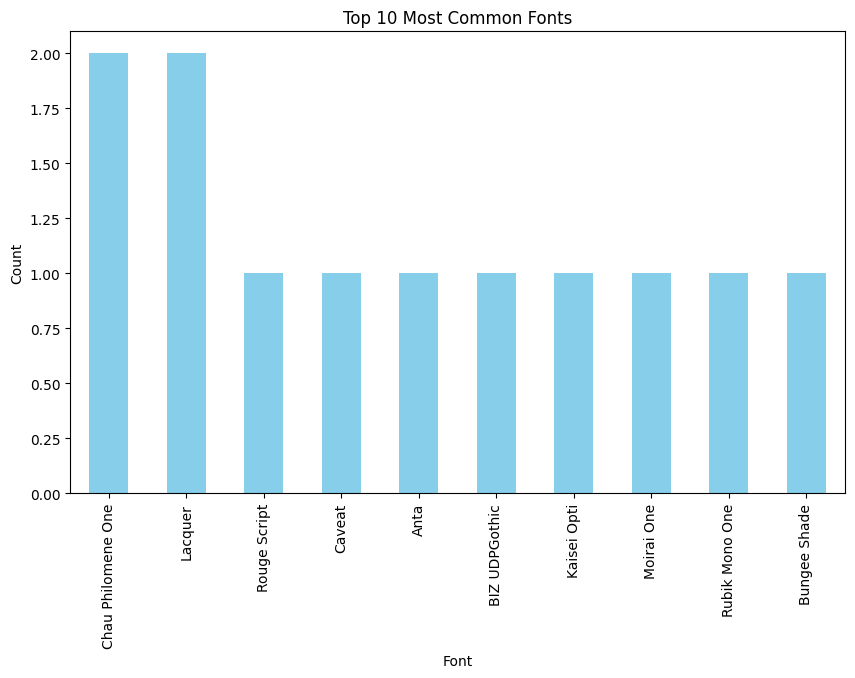

In [16]:
plt.figure(figsize=(10, 6))
df['font'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Most Common Fonts")
plt.xlabel("Font")
plt.ylabel("Count")
plt.show()

#### Color Palette Popularity

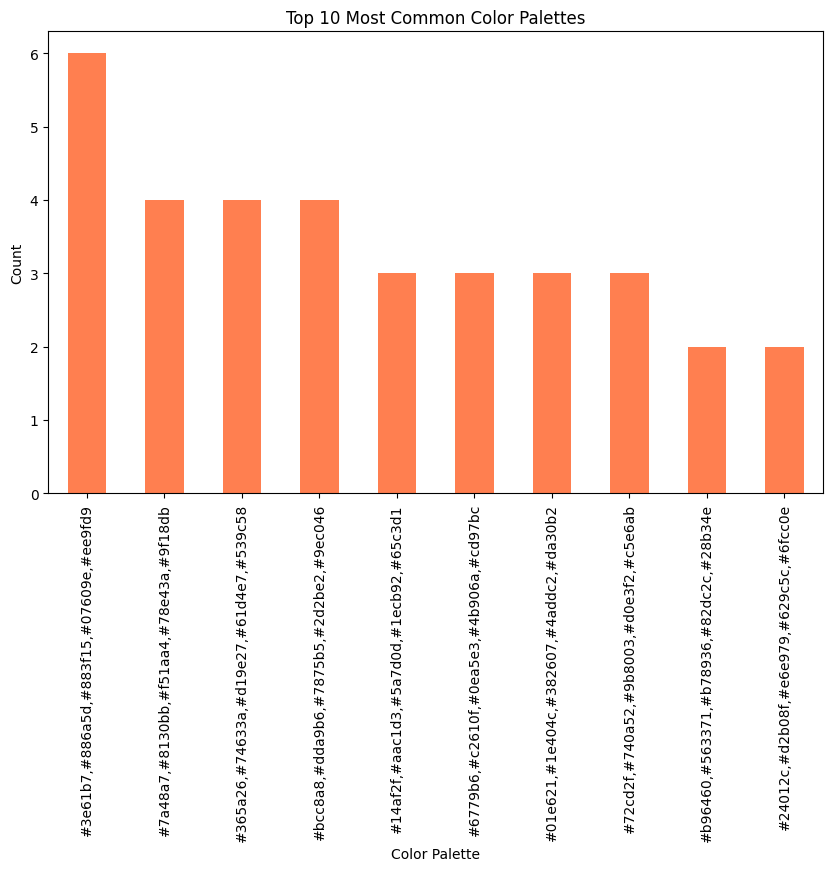

In [17]:
plt.figure(figsize=(10, 6))
df['color_palette'].value_counts().head(10).plot(kind='bar', color='coral')
plt.title("Top 10 Most Common Color Palettes")
plt.xlabel("Color Palette")
plt.ylabel("Count")
plt.show()

#### Word Cloud for descriptions

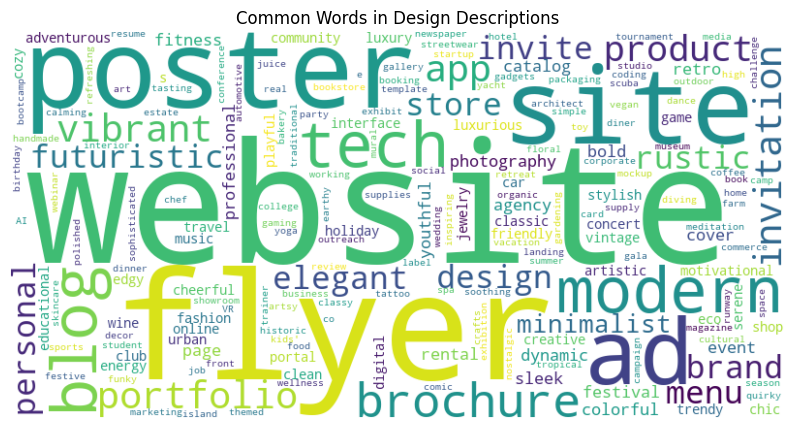

In [18]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['description']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Design Descriptions")
plt.show()

#### Box plot of description length

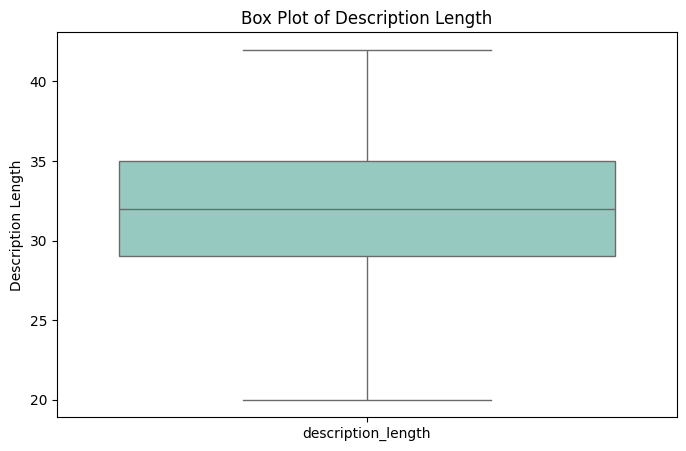

In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['description_length']], palette='Set3')
plt.title('Box Plot of Description Length')
plt.ylabel('Description Length')
plt.show()

#### Clustering: Font and Color Palette encoding

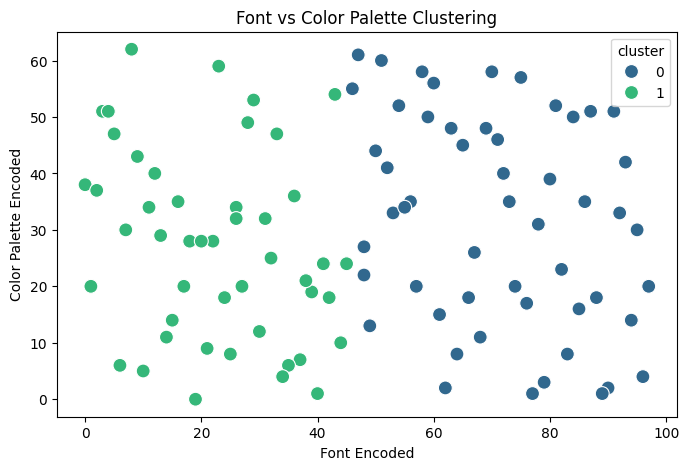

In [20]:
kmeans = KMeans(n_clusters=2, random_state=0)
df['cluster'] = kmeans.fit_predict(df[['font_encoded', 'color_palette_encoded']])

plt.figure(figsize=(8, 5))
sns.scatterplot(x='font_encoded', y='color_palette_encoded', hue='cluster', data=df, palette='viridis', s=100)
plt.title('Font vs Color Palette Clustering')
plt.xlabel('Font Encoded')
plt.ylabel('Color Palette Encoded')
plt.show()

In [21]:
df.to_csv("./Dataset/cleaned_combined_dataset.csv", index=False)
print("Cleaned dataset saved.")

Cleaned dataset saved.


#### Loading the cleaned dataset

In [22]:
dataset = pd.read_csv('./Dataset/cleaned_combined_dataset.csv')
dataset.head(5)

,description,font,color_palette,font_encoded,color_palette_encoded,description_sequence,description_length,contains_modern,contains_minimalist,contains_vintage,contains_bold,contains_elegant,palette_complexity,cluster
0,A modern tech startup website,Rouge Script,"#b96460,#563371,#b78936,#82dc2c,#28b34e",84,50,[ 2 9 10 83 4 0 0 0 0 0 0 0 0 0 0 ...,29,1,0,0,0,0,5,0
1,A vintage coffee shop menu,Patua One,"#35ae97,#4917e8,#3edec7,#2d0b25,#f8bb90",76,17,[ 2 45 84 46 18 0 0 0 0 0 0 0 0 0 0 ...,26,0,0,1,0,0,5,0
2,A minimalist photography portfolio,Numans,"#a90421,#cd8643,#dc2b6c,#10c5bb,#15c835",71,46,[ 2 28 29 13 0 0 0 0 0 0 0 0 0 0 0 ...,34,0,1,0,0,0,5,0
3,A vibrant fashion e-commerce site,Bangers,"#68f006,#e8aca2,#01b2fe,#f07642,#aa299d",13,29,[ 2 14 47 85 86 7 0 0 0 0 0 0 0 0 0 ...,33,0,0,0,0,0,5,1
4,A cozy bookstore flyer,Brawler,"#6779b6,#c2610f,#0ea5e3,#4b906a,#cd97bc",18,28,[ 2 48 87 5 0 0 0 0 0 0 0 0 0 0 0 ...,22,0,0,0,0,0,5,1


## Model Creation

#### Extracting inputs and outputs

In [23]:
# dataset["description_sequence"] = dataset["description_sequence"].str.strip("[],")  
# dataset["description_sequence"] = dataset["description_sequence"].apply(lambda x: "[" + x + "]") 

# description_sequences = np.array(dataset["description_sequence"].apply(eval).tolist())
# font_labels = np.array(dataset["font_encoded"])
# palette_labels = np.array(dataset["color_palette_encoded"])

def clean_sequence(seq):
    if not isinstance(seq, str) or seq.strip() == "":
        return []  
    seq = seq.strip("[],")  
    seq = ", ".join(seq.split()) 
    seq = "[" + seq + "]"  
    return seq

dataset["description_sequence"] = dataset["description_sequence"].apply(clean_sequence)

dataset["description_sequence"] = dataset["description_sequence"].apply(eval)

description_sequences = np.array(dataset["description_sequence"].tolist())
font_labels = np.array(dataset["font_encoded"])
palette_labels = np.array(dataset["color_palette_encoded"])


#### Splitting the dataset

In [24]:
X_train, X_test, y_font_train, y_font_test, y_palette_train, y_palette_test = train_test_split(
    description_sequences, font_labels, palette_labels, test_size=0.2, random_state=27
)

#### Define constants

In [25]:
vocab_size = max(description_sequences.max() + 1, 100)
embedding_dim = 64
max_seq_length = description_sequences.shape[1]

In [26]:
description_sequences = np.clip(description_sequences, 0, vocab_size - 1)

#### Build the model

In [27]:
description_input = layers.Input(shape=(max_seq_length,), name="Description_Input")

In [28]:
embedding_layer = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length)(description_input)

c:\Users\Tanay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
lstm_layer = layers.LSTM(128, return_sequences=True)(embedding_layer)

In [30]:
attention_layer = layers.Attention()([lstm_layer, lstm_layer])

In [31]:
global_pooling = layers.GlobalAveragePooling1D()(attention_layer)

In [32]:
font_dense = layers.Dense(64, activation="relu")(global_pooling)
font_output = layers.Dense(len(np.unique(font_labels)), activation="softmax", name="Font_Output")(font_dense)

In [33]:
palette_dense = layers.Dense(64, activation="relu")(global_pooling)
palette_output = layers.Dense(len(np.unique(palette_labels)), activation="softmax", name="Palette_Output")(palette_dense)

#### Defining and compiling the model

In [34]:
model = Model(inputs=description_input, outputs=[font_output, palette_output], name="Font_Color_Predictor")

In [35]:
model.compile(
    optimizer="adam",
    loss={
        "Font_Output": "sparse_categorical_crossentropy",
        "Palette_Output": "sparse_categorical_crossentropy"
    },
    metrics={
        "Font_Output": ["accuracy"],
        "Palette_Output": ["accuracy"]
    }
)

In [36]:
model.summary()

Model: "Font_Color_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Description_Input   │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 64)    │     14,656 │ Description_Inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 20, 128)   │     98,816 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 20, 128)   │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Font_Output (Dense) │ (None, 98)        │      6,370 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Palette_Output      │ (None, 63)        │      4,095 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 140,449 (548.63 KB)

 Trainable params: 140,449 (548.63 KB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [37]:
history = model.fit(
    X_train, {"Font_Output": y_font_train, "Palette_Output": y_palette_train},
    validation_data=(X_test, {"Font_Output": y_font_test, "Palette_Output": y_palette_test}),
    epochs=100,
    batch_size=32
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - Font_Output_accuracy: 0.0000e+00 - Font_Output_loss: 4.5863 - Palette_Output_accuracy: 0.0203 - Palette_Output_loss: 4.1443 - loss: 8.7304 - val_Font_Output_accuracy: 0.0000e+00 - val_Font_Output_loss: 4.5900 - val_Palette_Output_accuracy: 0.1000 - val_Palette_Output_loss: 4.1425 - val_loss: 8.7325
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - Font_Output_accuracy: 0.0180 - Font_Output_loss: 4.5835 - Palette_Output_accuracy: 0.0445 - Palette_Output_loss: 4.1402 - loss: 8.7237 - val_Font_Output_accuracy: 0.0000e+00 - val_Font_Output_loss: 4.5954 - val_Palette_Output_accuracy: 0.1000 - val_Palette_Output_loss: 4.1440 - val_loss: 8.7394
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - Font_Output_accuracy: 0.0102 - Font_Output_loss: 4.5816 - Palette_Output_accuracy: 0.0344 - Palette_Output_loss: 4.1374 - loss: 8.7186 - val_Font_Output_accuracy: 0.0000e+00 - val_Font_Output_loss: 4.6019 - val_Palette_Output_accuracy: 0.0000e+00 

In [38]:
model.save("design_suggestion_model.h5")

#### Evaluating the model

In [39]:
model.summary()


Model: "Font_Color_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Description_Input   │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 64)    │     14,656 │ Description_Inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 20, 128)   │     98,816 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 20, 128)   │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Font_Output (Dense) │ (None, 98)        │      6,370 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Palette_Output      │ (None, 63)        │      4,095 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 421,349 (1.61 MB)

 Trainable params: 140,449 (548.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 280,900 (1.07 MB)

In [40]:
results = model.evaluate(X_test, {"Font_Output": y_font_test, "Palette_Output": y_palette_test})
print(f"Test Loss and Accuracy: {results}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - Font_Output_accuracy: 0.0000e+00 - Font_Output_loss: 15.2334 - Palette_Output_accuracy: 0.0000e+00 - Palette_Output_loss: 9.3973 - loss: 24.6308
Test Loss and Accuracy: [24.630767822265625, 15.233423233032227, 9.397345542907715, 0.0, 0.0]


#### Testing the model

In [41]:
loaded_model = tf.keras.models.load_model('./design_suggestion_model.h5')
print("Model loaded for testing.")

Model loaded for testing.


In [42]:
y_font_pred, y_palette_pred = loaded_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


In [43]:
y_font_pred_classes = np.argmax(y_font_pred, axis=1)
y_palette_pred_classes = np.argmax(y_palette_pred, axis=1)

In [44]:
print("Font Classification Report:")
print(classification_report(y_font_test, y_font_pred_classes))
print("Color Palette Classification Report:")
print(classification_report(y_palette_test, y_palette_pred_classes))

Font Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       1.0
          10       0.00      0.00      0.00       0.0
          16       0.00      0.00      0.00       1.0
          17       0.00      0.00      0.00       1.0
          19       0.00      0.00      0.00       1.0
          22       0.00      0.00      0.00       1.0
          26       0.00      0.00      0.00       1.0
          34       0.00      0.00      0.00       1.0
          36       0.00      0.00      0.00       1.0
          37       0.00      0.00      0.00       1.0
          38       0.00      0.00      0.00       0.0
          40       0.00      0.00      0.00       1.0
          43       0.00      0.00      0.00       0.0
          46       0.00      0.00      0.00       0.0

c:\Users\Tanay\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tanay\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tanay\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [45]:
print("Font Confusion Matrix:")
print(confusion_matrix(y_font_test, y_font_pred_classes))
print("Color Palette Confusion Matrix:")
print(confusion_matrix(y_palette_test, y_palette_pred_classes))

Font Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [

#### Plotting training history

In [46]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['Font_Output_accuracy'], label="Font Train Accuracy")
    plt.plot(history.history['val_Font_Output_accuracy'], label="Font Validation Accuracy")
    plt.plot(history.history['Palette_Output_accuracy'], label="Palette Train Accuracy")
    plt.plot(history.history['val_Palette_Output_accuracy'], label="Palette Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['Font_Output_loss'], label="Font Train Loss")
    plt.plot(history.history['val_Font_Output_loss'], label="Font Validation Loss")
    plt.plot(history.history['Palette_Output_loss'], label="Palette Train Loss")
    plt.plot(history.history['val_Palette_Output_loss'], label="Palette Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Over Epochs")
    plt.show()

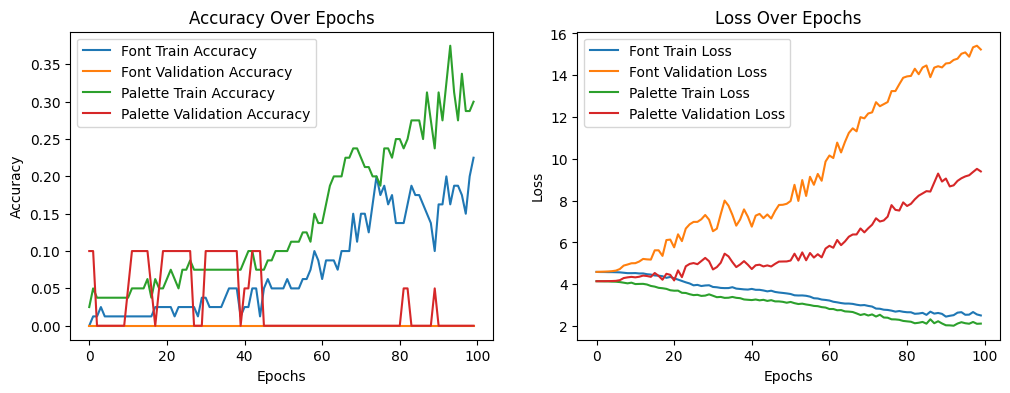

In [47]:
plot_history(history)